# Running activity analysis

Exported activities of a garmin user who has run almost consistently for 4 years (2015-2018).
The activities were recorded using devices from Garmin Forerunner series, FR225, FR235, FR735.

#### Attributes of interest
- **Activity Type:** running, treadmill, cycling -> we'll filter out only running activities
- **Date:** activity date
- **Title:** activity name which is auto-generated by Garmin. The runner usually names his activities meaningful manually.
- **Distance:** distance in kilometer
- **Calories:** calculated calories used from the activity
- **Time:** duration in text, e.g., 1:30:45
- **Avg HR:** average heart rate of the whole activity
- **Avg Run Cadence:** average run cadence (spm - stride per minute)
- **Avg Pace:** pace in minute/km represented in m:ss format. A **lower** pace means **faster**.
- **Avg Stride Length:** average stride length in meter

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
filename = 'datasets/Activities.csv'

cols = ['Activity Type', 'Date', 'Title', 'Distance', 'Calories', 'Time', 
        'Avg HR', 'Max HR', 'Avg Run Cadence', 'Max Run Cadence', 
        'Avg Pace', 'Best Pace', 'Avg Stride Length']

colnames = ['type', 'date', 'title', 'distance', 'calories', 'time', 
           'avg_hr', 'max_hr', 'avg_cadence', 'max_cadence',
           'avg_pace','max_pace', 'avg_stride_length']


df = pd.read_csv(filename, parse_dates=['Date'], usecols=cols,
                na_values='--', thousands=',')

df.columns = colnames
# df.avg_stride_length.replace(0, np.nan, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Data columns (total 13 columns):
type                 705 non-null object
date                 705 non-null datetime64[ns]
title                705 non-null object
distance             705 non-null float64
calories             686 non-null float64
time                 705 non-null object
avg_hr               687 non-null float64
max_hr               687 non-null float64
avg_cadence          593 non-null float64
max_cadence          593 non-null float64
avg_pace             693 non-null object
max_pace             694 non-null object
avg_stride_length    705 non-null float64
dtypes: datetime64[ns](1), float64(7), object(5)
memory usage: 71.7+ KB


### Workout type
A label is given for each activity manually to indicate his intention of that particular run. Workout types can be easy, tempo, interval, long run and race, and others, when his intention is not clearly stated, the type will be just 'run'.

I also added the train/race flag to indicate whether this acvitiy is a race or not.

In [3]:
labels = pd.read_csv('datasets/activity_labels.csv', usecols=['workout'])
df = df.join(labels)

In [4]:
run_cols = ['date','title','distance','calories','time','avg_hr', 'avg_cadence', 'avg_pace', 'avg_stride_length','workout']

runs = df.query('type == "running"')[run_cols]

runs['train/race'] = runs.workout.map(lambda x: 'race' if x == 'race' else 'train').astype('category')

# Inspect missing values
# runs[runs.isnull().any(axis=1)]

# Seems like it's okay to just drop all rows with missing values, still good amount of data
runs.dropna(inplace=True)
runs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 536 entries, 0 to 680
Data columns (total 11 columns):
date                 536 non-null datetime64[ns]
title                536 non-null object
distance             536 non-null float64
calories             536 non-null float64
time                 536 non-null object
avg_hr               536 non-null float64
avg_cadence          536 non-null float64
avg_pace             536 non-null object
avg_stride_length    536 non-null float64
workout              536 non-null object
train/race           536 non-null category
dtypes: category(1), datetime64[ns](1), float64(5), object(4)
memory usage: 46.7+ KB


#### Time conversion
Convert duration string from time and pace fields with posssible formats as h:mm:ss, m:ss, m:ss.sss, s.ss to a numerical number of seconds.

In [5]:
# ## x: time duration strings in the possible formats of h:mm:ss, m:ss, m:ss.sss, s.ss
def duration_to_sec(x):
    result = np.nan
    s = x.split(':')
    if(len(s) == 1):
        result = float(s[0])
    elif(len(s) == 2):
        result = timedelta(minutes=int(s[0]), seconds=float(s[1])).total_seconds()
    elif (len(s) == 3):
        result = timedelta(hours=int(s[0]), minutes=int(s[1]), seconds=float(s[2])).total_seconds()
    else:
        raise ValueError('Unexpected time format: {}'.format(x))
        
    return result

In [6]:
runs['time'] = runs['time'].apply(duration_to_sec)
runs['avg_pace'] = runs['avg_pace'].apply(duration_to_sec)

# bins=[0,5,10,15,20,25,30,35,40,100]
# labels=['0-5K','6-10K','11-15K','16-20K','21-25K','26-30K','31-35K','36-40K','>40K']
# runs['distance_group'] = pd.cut(runs['distance'].apply(int),bins=bins,labels=labels, include_lowest=True)

In [7]:
# Stride length missing values come as zeros
runs['avg_stride_length'].replace(0, np.nan, inplace=True)
runs['avg_stride_length'].fillna(runs['avg_stride_length'].mean(), inplace=True)

runs.head()

,date,title,distance,calories,time,avg_hr,avg_cadence,avg_pace,avg_stride_length,workout,train/race
0,2018-10-12 21:10:12,Easy Run after sick,5.04,365.0,2089.0,149.0,156.0,414.0,0.94,easy,train
1,2018-10-09 23:21:25,Lat Phrao Run,5.09,343.0,1886.0,148.0,162.0,370.0,0.99,run,train
2,2018-10-07 22:21:38,Lat Phrao Run,11.01,769.0,4110.0,155.0,163.0,373.0,0.99,run,train
6,2018-10-03 20:25:54,Lat Phrao Run,7.85,538.0,2583.0,169.0,166.0,329.0,1.09,run,train
7,2018-10-02 20:05:12,Easy Run,5.04,378.0,1934.0,158.0,159.0,384.0,0.99,easy,train


## Exploratory Data Analysis

In [8]:
sns.set_style('whitegrid')

# Convert time & avg_pace to minute
data = runs.copy()
data['time'] = data['time']/60
data['avg_pace'] = data['avg_pace']/60

weekdays = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

# Generate more variables
data = data.assign(year=data['date'].dt.year,
                    month=data['date'].dt.month,#.map(lambda x: months[x-1]),
                    week=data['date'].dt.week,
                    dayofweek=data['date'].dt.dayofweek)#.map(lambda x: weekdays[x]))

data.head()

,date,title,distance,calories,time,avg_hr,avg_cadence,avg_pace,avg_stride_length,workout,train/race,year,month,week,dayofweek
0,2018-10-12 21:10:12,Easy Run after sick,5.04,365.0,34.816667,149.0,156.0,6.900000,0.94,easy,train,2018,10,41,4
1,2018-10-09 23:21:25,Lat Phrao Run,5.09,343.0,31.433333,148.0,162.0,6.166667,0.99,run,train,2018,10,41,1
2,2018-10-07 22:21:38,Lat Phrao Run,11.01,769.0,68.500000,155.0,163.0,6.216667,0.99,run,train,2018,10,40,6
6,2018-10-03 20:25:54,Lat Phrao Run,7.85,538.0,43.050000,169.0,166.0,5.483333,1.09,run,train,2018,10,40,2
7,2018-10-02 20:05:12,Easy Run,5.04,378.0,32.233333,158.0,159.0,6.400000,0.99,easy,train,2018,10,40,1


#### Numbers of workouts

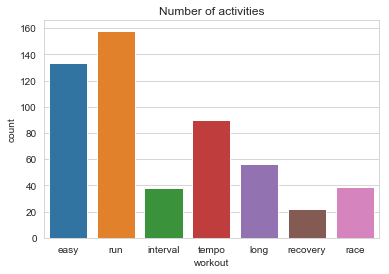

In [11]:
sns.countplot(x='workout', data=data)
plt.title('Number of activities');

#### Distance of trains and races
Runners tend to train before their races, typically run in a training schedule for 3-4 months before the target race.
This also reflects in an amount of running distance. The more distance run, the performace is likely to be better.

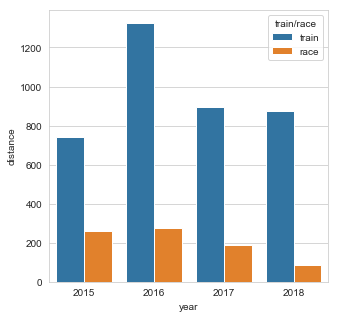

In [12]:
plt.figure(figsize=(5,5))
sns.barplot(data = data.groupby(['train/race','year'], as_index=False)['distance'].sum(),
            x = 'year', y='distance',hue='train/race',hue_order=['train','race']);

#### Comparing Train/Race behaviors
Typically we can expect train and race behavior to be different. While training, the runner trained with different workouts, e.g., easy, tempo, interval, or long run. His training stat should vary a lot, more than racing, and we can expect a better performance with races.

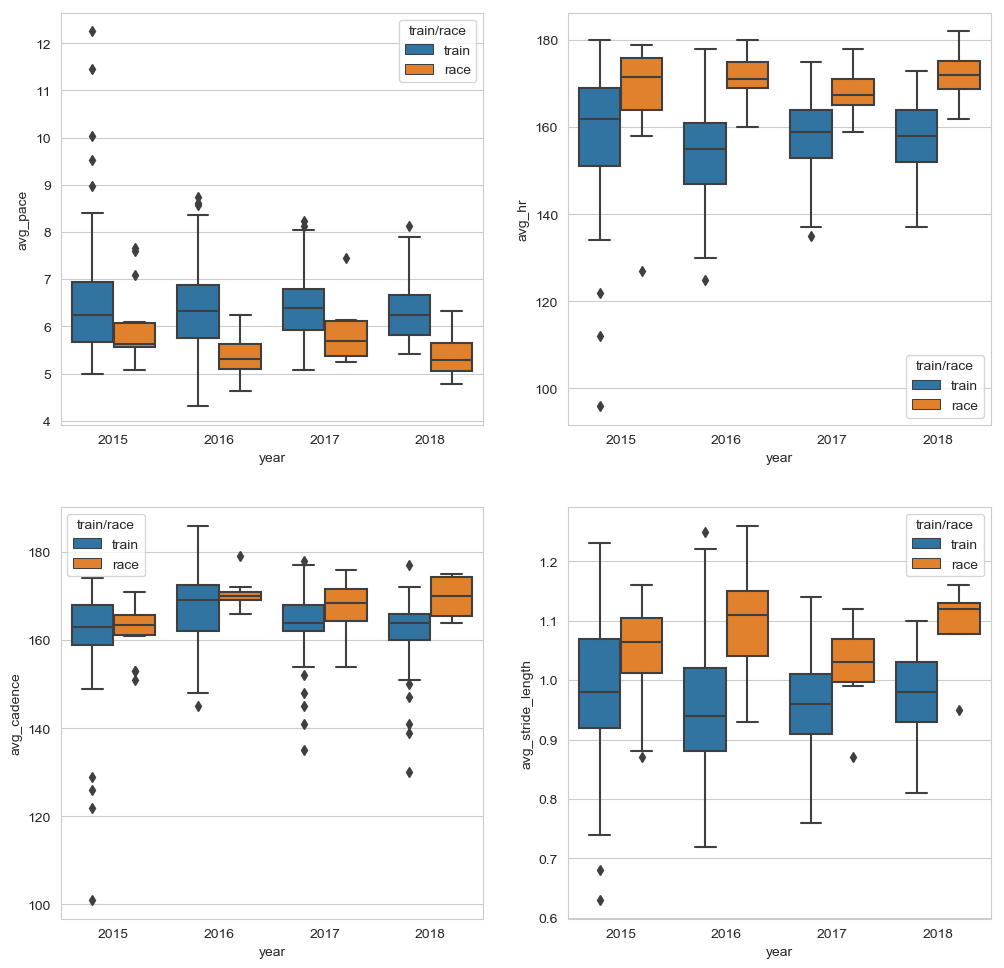

In [13]:
f, axes = plt.subplots(2, 2, figsize=(12,12), dpi=100)
sns.boxplot(data = data, x = 'year', y='avg_pace',
            hue='train/race',hue_order=['train','race'], ax=axes[0,0]);
sns.boxplot(data = data, x = 'year', y='avg_hr',
            hue='train/race',hue_order=['train','race'], ax=axes[0,1]);
sns.boxplot(data = data, x = 'year', y='avg_cadence',
            hue='train/race',hue_order=['train','race'], ax=axes[1,0]);
sns.boxplot(data = data, x = 'year', y='avg_stride_length',
            hue='train/race',hue_order=['train','race'], ax=axes[1,1]);

plt.savefig('output/boxplot_by_year.png')

### Feature Distributions by workout

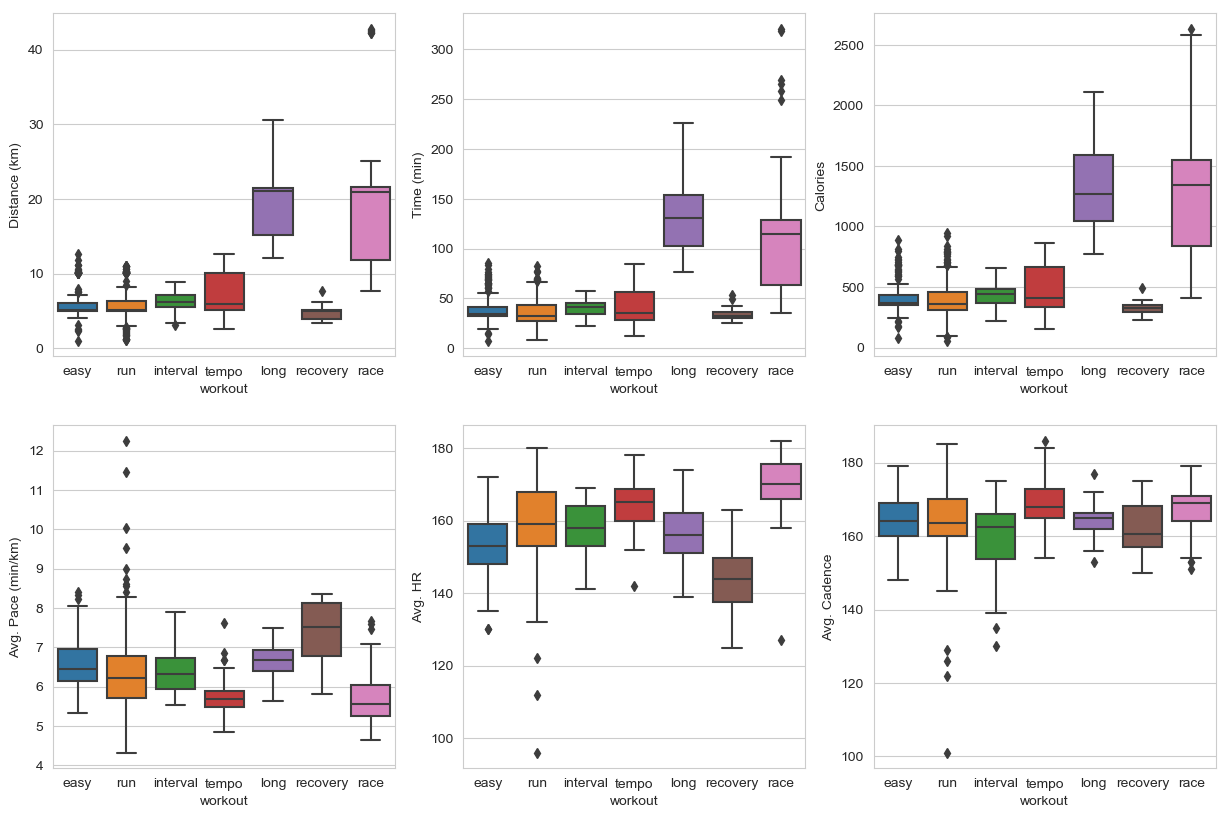

In [24]:
f, axes = plt.subplots(2,3, figsize=(15,10), dpi=100)
ax = sns.boxplot(x='workout', y='distance', data=data, ax=axes[0,0])
ax.set(ylabel='Distance (km)')
ax = sns.boxplot(x='workout', y='time', data=data, ax=axes[0,1])
ax.set(ylabel='Time (min)')
ax = sns.boxplot(x='workout', y='calories', data=data, ax=axes[0,2])
ax.set(ylabel='Calories')
ax = sns.boxplot(x='workout', y='avg_pace', data=data, ax=axes[1,0])
ax.set(ylabel='Avg. Pace (min/km)')
ax = sns.boxplot(x='workout', y='avg_hr', data=data, ax=axes[1,1])
ax.set(ylabel='Avg. HR')
ax = sns.boxplot(x='workout', y='avg_cadence', data=data, ax=axes[1,2])
ax.set(ylabel='Avg. Cadence')
# ax = sns.boxplot(x='workout', y='avg_stride_length', data=data, ax=axes[2,0])
# ax.set(ylabel='Avg. Stride Length (m)')

plt.savefig('output/boxplot_by_workout.png')

### Correlations

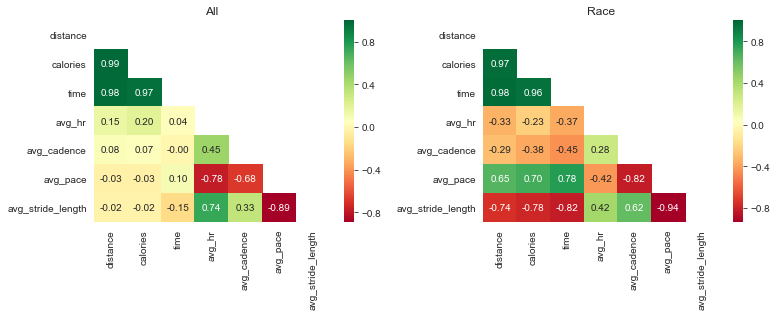

In [18]:
cols = ['distance','calories','time','avg_hr','avg_cadence','avg_pace','avg_stride_length']

f, axes = plt.subplots(1,2, figsize=(11,4.5))

corr = data[cols].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(corr, mask=mask, cmap='RdYlGn', annot=True, fmt='.2f', ax=axes[0]);
ax.set_title('All')

corr = data[data['train/race']=='race'][cols].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(corr, mask=mask, cmap='RdYlGn', annot=True, fmt='.2f', ax=axes[1])
ax.set_title('Race')
plt.tight_layout();

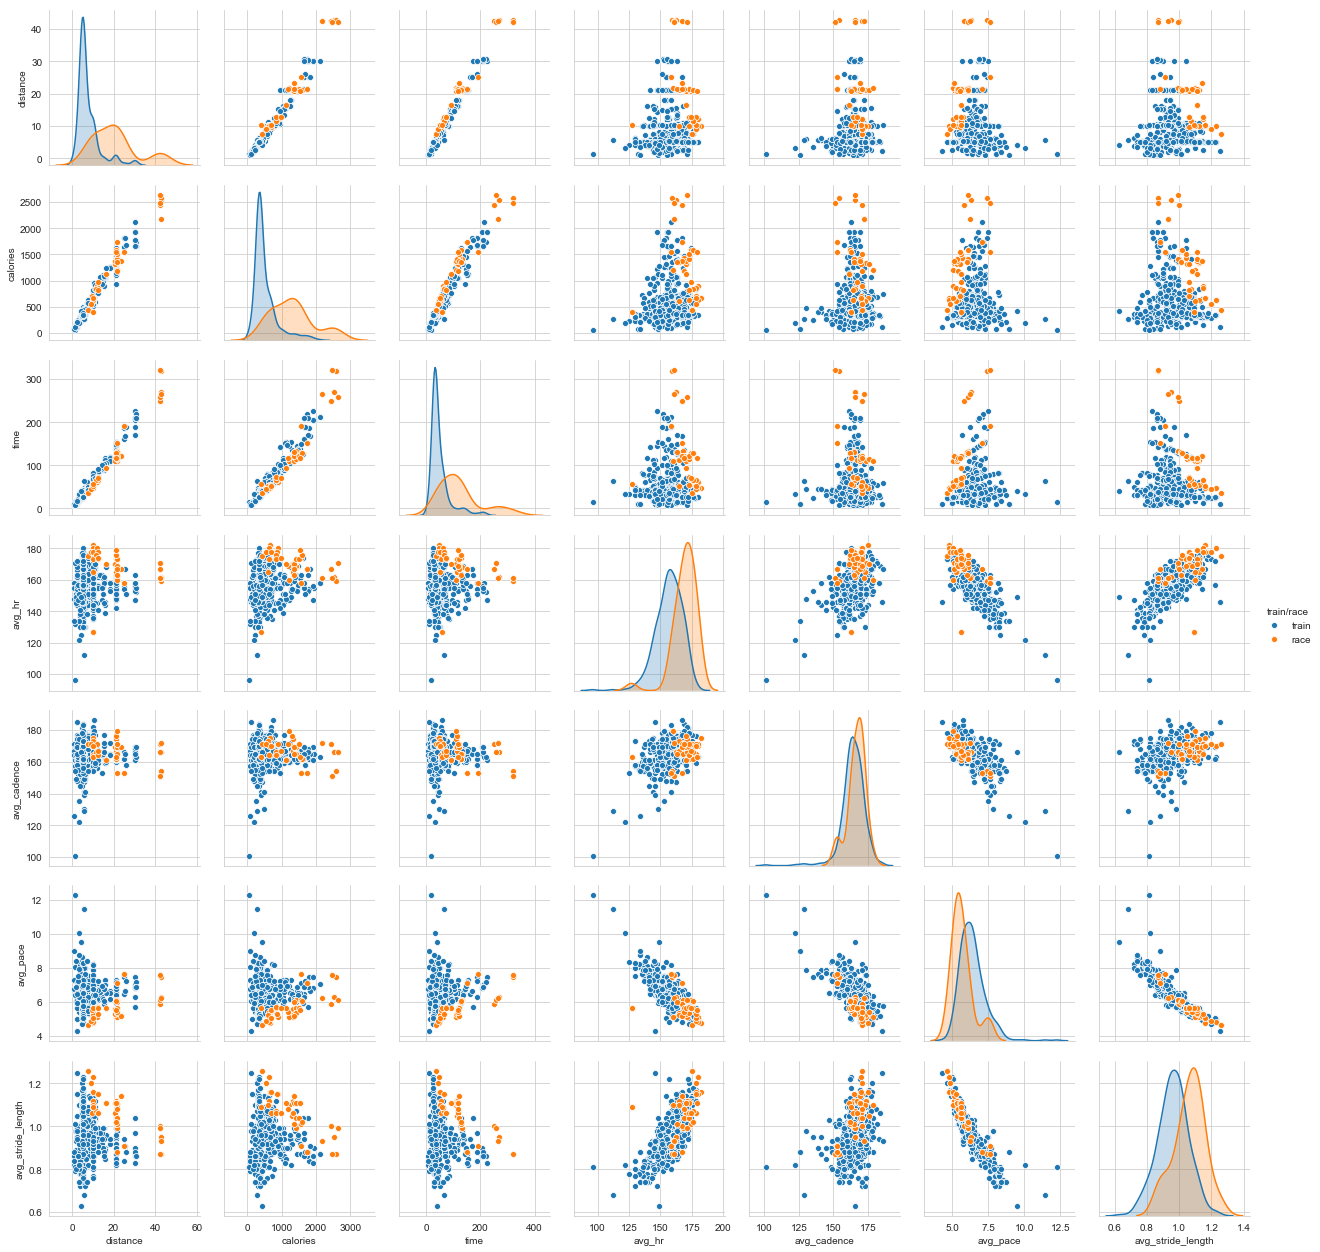

In [19]:
sns.pairplot(data, vars=cols, kind='scatter', diag_kind='kde', 
             hue='train/race', hue_order=['train','race']);
plt.savefig('output/pairplot.png')

#### Separate pace groups
See how pace distribution is and consider cutting pace into 3 groups as Fast, Average, Slow.

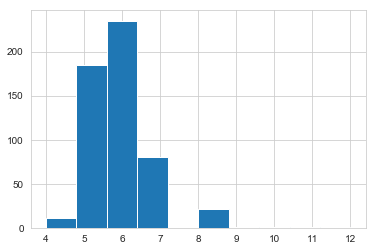

In [20]:
data['avg_pace'].astype(int).hist();

## To burn more calories, run long or run fast?
As the correlation above suggests, distance and time spent in a run are highly correlated with colories burnt while pace/speed matters a little.

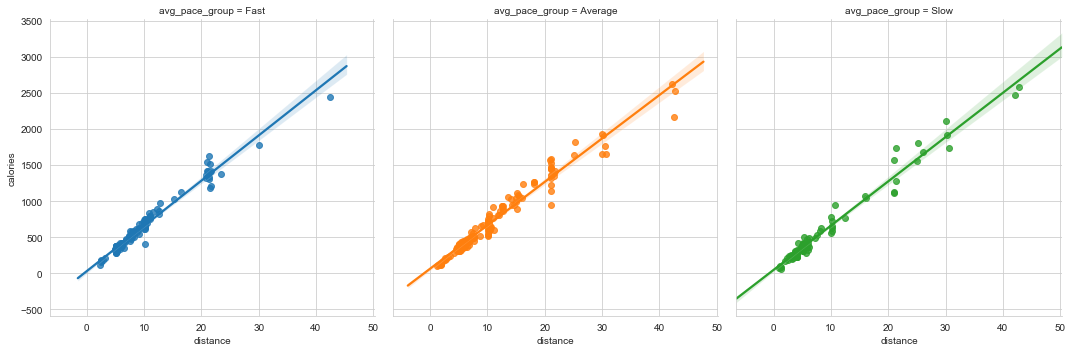

In [21]:
bins=[0,6,7,100]
# Fast: below pace 6, Average: pace 6, Slow: 7 and above
labels=['Fast','Average','Slow']
data['avg_pace_group'] = pd.cut(data['avg_pace'],bins=bins,labels=labels, include_lowest=True)
sns.lmplot(x='distance', y='calories', hue='avg_pace_group', col='avg_pace_group', data=data);

### Explore cadence and stride length relation


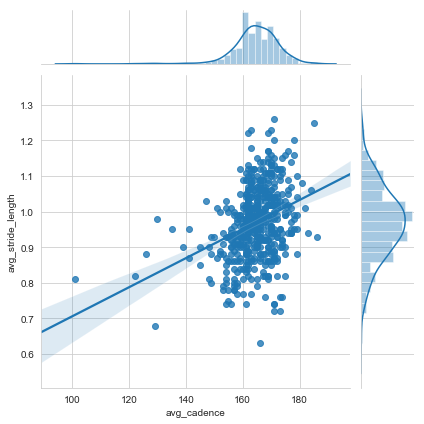

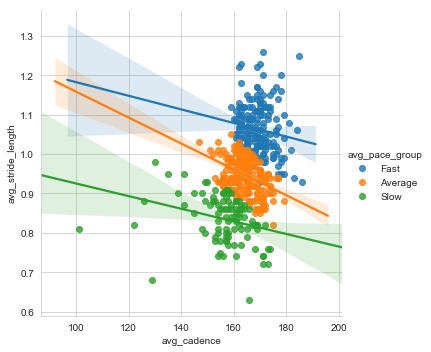

In [22]:
sns.jointplot(x='avg_cadence', y='avg_stride_length', kind='reg', data=data);
sns.lmplot(x='avg_cadence', y='avg_stride_length', data=data, hue='avg_pace_group');

### Heatmaps

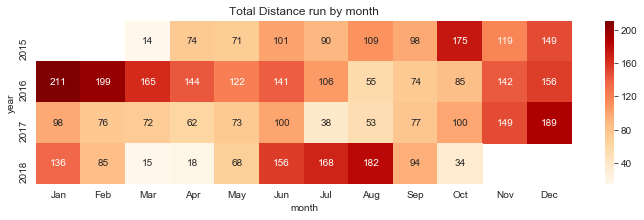

In [18]:
plt.figure(figsize=(12,3))
heatmap = data.groupby(['month','year'], as_index=False)['distance'].sum()
heatmap['month'] = heatmap['month'].map(lambda x: months[x-1])
heatmap = heatmap.pivot(index='year',columns='month', values='distance')
heatmap = heatmap.loc[:,months]
ax= sns.heatmap(heatmap, annot=True, fmt='.0f', cmap='OrRd')
ax.set_title('Total Distance run by month');

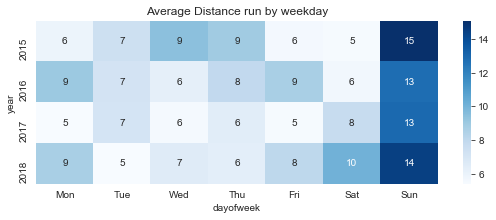

In [19]:
plt.figure(figsize=(9,3))
heatmap = data.groupby(['year','dayofweek'], as_index=False)['distance'].mean()
heatmap['dayofweek'] = heatmap['dayofweek'].map(lambda x: weekdays[x])
heatmap = heatmap.pivot(index='year',columns='dayofweek', values='distance')
heatmap = heatmap.loc[:,weekdays]
ax = sns.heatmap(heatmap, annot=True, fmt='.0f', cmap='Blues')
ax.set_title('Average Distance run by weekday');

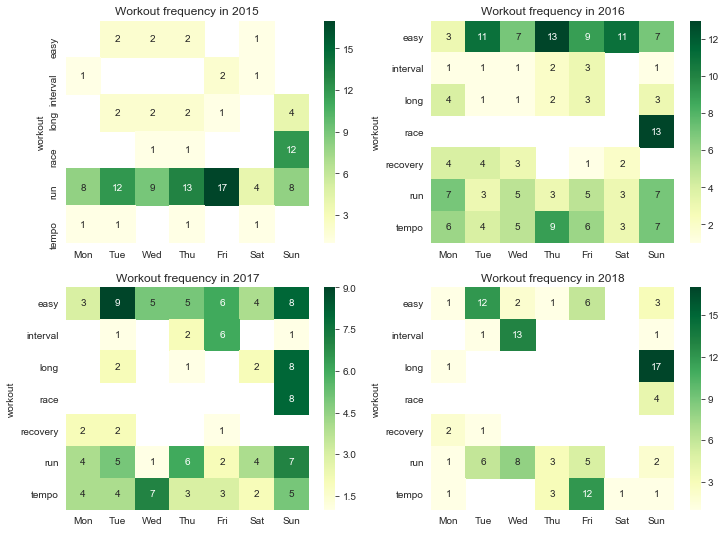

In [20]:
f, axes = plt.subplots(2,2, figsize=(12,9))

for i, y in enumerate(np.arange(2015, 2019)):
    heatmap = data[data['year']==y].groupby(['workout','dayofweek'], as_index=False).size().reset_index(name='count')
    heatmap = heatmap.pivot('workout','dayofweek','count')
    heatmap.columns = weekdays
    ax = sns.heatmap(heatmap, annot=True, fmt='.0f', cmap='YlGn', ax=axes.flatten()[i])
    ax.set_title('Workout frequency in {}'.format(y))

## Simple Calories Prediction

In [24]:
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

X = data[['distance','time']].values
y = data['calories'].values

scaler = StandardScaler()
reg = LinearRegression()

steps = [('scaler', scaler),
         ('reg', reg)]

pipeline = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

pipeline.fit(X_train, y_train)

print('Score: {}'.format(pipeline.score(X_test, y_test)))

Score: 0.9629420738364624


In [25]:
new_samples = [[5,20], [10, 60], [10,50], [10,40],
               [21.1,120], [21.1,180], [42.195, 240], [42.195, 300]]
# new_samples = [[5,4], [10, 6], [10,5], [10,4],
#                [21.1,5.68], [21.1,8.5], [42.195, 5.68], [42.195, 7.1]]

y_pred = pipeline.predict(new_samples)
pd.DataFrame(np.hstack([new_samples, y_pred.reshape(-1,1)]),
             columns=['Distance (km)','Time (min)','Predicted Calories'])

,Distance (km),Time (min),Predicted Calories
0,5.000,20.0,357.429594
1,10.000,60.0,658.989483
2,10.000,50.0,663.126814
3,10.000,40.0,667.264145
4,21.100,120.0,1340.367948
5,21.100,180.0,1315.543963
6,42.195,240.0,2632.822743
7,42.195,300.0,2607.998758


In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import scale

# TODO: try hierarchical clustering